* Kia Duan (wd3fg)
* Jingyi Sun (js6sm)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GMM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Read in data
path = "/Users/kia/Desktop/SYS 6016/Midterm Project/h1b-disclosure-dataset/H1B Disclosure Dataset Files/"
file = "1. Master H1B Dataset.csv"
h1b_df = pd.read_csv(path+file,low_memory = False, encoding = "ISO-8859-1")
h1b_df.head()

,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIEDWITHDRAWN
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,WITHDRAWN
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIEDWITHDRAWN


# Data Cleaning & Preprocessing

## Impute Missing Values

In [3]:
h1b_df.isnull().sum()

CASE_SUBMITTED_DAY           0
CASE_SUBMITTED_MONTH         0
CASE_SUBMITTED_YEAR          0
DECISION_DAY                 0
DECISION_MONTH               0
DECISION_YEAR                0
VISA_CLASS                   0
EMPLOYER_NAME               39
EMPLOYER_STATE              10
EMPLOYER_COUNTRY             0
SOC_NAME                     0
NAICS_CODE                   2
TOTAL_WORKERS                0
FULL_TIME_POSITION           3
PREVAILING_WAGE              0
PW_UNIT_OF_PAY              33
PW_SOURCE                   33
PW_SOURCE_YEAR              31
PW_SOURCE_OTHER              0
WAGE_RATE_OF_PAY_FROM        0
WAGE_RATE_OF_PAY_TO          0
WAGE_UNIT_OF_PAY             4
H-1B_DEPENDENT           10300
WILLFUL_VIOLATOR         10301
WORKSITE_STATE               0
WORKSITE_POSTAL_CODE         0
CASE_STATUS                  0
dtype: int64

In [4]:
# delete rows with employer name, state and NAICS_CODE missing
filter_df1 = h1b_df[h1b_df['EMPLOYER_NAME'].notnull()]
filter_df2 = filter_df1[filter_df1['EMPLOYER_STATE'].notnull()]
filter_df3 = filter_df2[filter_df2['NAICS_CODE'].notnull()]

In [5]:
# This is an extension by D.Brown to sveitser, 2014 https://stackoverflow.com/users/469992/sveitser
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        
        Columns of dtype floating point are imputed with the mean.

        Columns of other types are imputed with median of the column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') 
                               else X[c].mean() if X[c].dtype == np.dtype('f')
                                else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [6]:
# doing the imputation
clean_df = DataFrameImputer().fit_transform(filter_df3)
clean_df.isnull().sum()

CASE_SUBMITTED_DAY       0
CASE_SUBMITTED_MONTH     0
CASE_SUBMITTED_YEAR      0
DECISION_DAY             0
DECISION_MONTH           0
DECISION_YEAR            0
VISA_CLASS               0
EMPLOYER_NAME            0
EMPLOYER_STATE           0
EMPLOYER_COUNTRY         0
SOC_NAME                 0
NAICS_CODE               0
TOTAL_WORKERS            0
FULL_TIME_POSITION       0
PREVAILING_WAGE          0
PW_UNIT_OF_PAY           0
PW_SOURCE                0
PW_SOURCE_YEAR           0
PW_SOURCE_OTHER          0
WAGE_RATE_OF_PAY_FROM    0
WAGE_RATE_OF_PAY_TO      0
WAGE_UNIT_OF_PAY         0
H-1B_DEPENDENT           0
WILLFUL_VIOLATOR         0
WORKSITE_STATE           0
WORKSITE_POSTAL_CODE     0
CASE_STATUS              0
dtype: int64

## Create a variable as our new response variable based on CASE_STATUS

In [7]:
clean_df.loc[clean_df['CASE_STATUS'] == 'CERTIFIED', 'OUTCOME'] = 'CERTIFIED'
clean_df.loc[clean_df['CASE_STATUS'] == 'WITHDRAWN', 'OUTCOME'] = 'NOTCERTIFIED'
clean_df.loc[clean_df['CASE_STATUS'] == 'CERTIFIEDWITHDRAWN', 'OUTCOME'] = 'CERTIFIED'
clean_df.loc[clean_df['CASE_STATUS'] == 'DENIED', 'OUTCOME'] = 'NOTCERTIFIED'
clean_df = clean_df.drop(['CASE_STATUS'],axis = 1)
clean_df.head()

,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,OUTCOME
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIED
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIED
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIED
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,NOTCERTIFIED
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIED


## Convert the date columns

In [8]:
clean_df['CASE_SUBMITTED'] = clean_df['CASE_SUBMITTED_YEAR'].astype(str)+ '-'+ clean_df['CASE_SUBMITTED_MONTH'].astype(str) +'-'+ clean_df['CASE_SUBMITTED_DAY'].astype(str)
clean_df['CASE_SUBMITTED'] = pd.to_datetime(clean_df['CASE_SUBMITTED'])
clean_df['CASE_SUBMITTED'].head()

0   2016-02-24
1   2016-03-04
2   2016-03-10
3   2016-09-28
4   2015-02-22
Name: CASE_SUBMITTED, dtype: datetime64[ns]

In [9]:
clean_df['DECISION'] = clean_df['DECISION_YEAR'].astype(str)+ '-'+ clean_df['DECISION_MONTH'].astype(str) +'-'+ clean_df['DECISION_DAY'].astype(str)
clean_df['DECISION'] = pd.to_datetime(clean_df['DECISION'])
clean_df['DECISION'].head()

0   2016-10-01
1   2016-10-01
2   2016-10-01
3   2016-10-01
4   2016-10-02
Name: DECISION, dtype: datetime64[ns]

## Subset the dataset by selecting all analyst/engineer jobs

In [10]:
clean_df['SOC_NAME']=clean_df['SOC_NAME'].str.upper()
clean_df['SOC_NAME'].value_counts()

COMPUTER OCCUPATION                  245851
ANALYSTS                             112772
ENGINEERS                             43842
SCIENTIST                             17934
FINANCE                               13199
DOCTORS                               13079
EDUCATION                             12369
MARKETING                             10649
ACCOUNTANTS                           10589
IT MANAGERS                            6147
MANAGERS                               5167
MATHEMATICIANS AND STATISTICIANS       5046
HUMAN RESOURCES                        3132
ARCHITECTURE                           2371
LAWYERS AND LEGAL SUPPORT WORKERS      2214
DESIGNERS                              2075
LAB TECHNICIANS                        2044
GRAPHIC DESIGNERS                      1992
LOGISTICIANS                           1772
HEALTHCARE                             1749
INTERNIST                              1524
PUBLIC RELATIONS                       1129
BUSINESS OPERATIONS SPECIALIST  

In [11]:
subset1 = clean_df[clean_df.SOC_NAME.str.match(r'.*ANALYSTS.*', na=False)]
subset2 = clean_df[clean_df.SOC_NAME.str.match(r'.*ENGINEERS.*', na=False)]
subset_df = pd.concat([subset1,subset2],axis=0)
subset_df.shape

(156854, 29)

## Keep the top 10 most popular states + VA +DC

In [12]:
subset_df['WORKSITE_STATE'].value_counts().head(10)

CA    30251
TX    17133
NY    13415
NJ    12087
MA     7063
WA     6973
FL     5545
IL     5462
PA     5422
GA     5093
Name: WORKSITE_STATE, dtype: int64

In [13]:
top_states = ['CA','TX','NY','NJ','MA','WA','FL','IL','PA','GA','VA','DC']
subset_df = subset_df.loc[subset_df['WORKSITE_STATE'].isin(top_states)]
subset_df['WORKSITE_STATE'].value_counts()

CA    30251
TX    17133
NY    13415
NJ    12087
MA     7063
WA     6973
FL     5545
IL     5462
PA     5422
GA     5093
VA     5080
DC      853
Name: WORKSITE_STATE, dtype: int64

## Balance the data by downsampling the majority class

In [14]:
subset_df['OUTCOME'].value_counts()

CERTIFIED       112431
NOTCERTIFIED      1946
Name: OUTCOME, dtype: int64

In [15]:
balance_df = subset_df.groupby('OUTCOME')
balance_df = balance_df.apply(lambda x: x.sample(balance_df.size().min(),random_state=42).reset_index(drop=True))
balance_df['OUTCOME'].value_counts()

NOTCERTIFIED    1946
CERTIFIED       1946
Name: OUTCOME, dtype: int64

## Convert response variable to 1 & 0

In [16]:
balance_df['OUTCOME'] = balance_df['OUTCOME'].eq('CERTIFIED').mul(1)

## Convert categorical explanatory variables to dummies & drop unuseful variables

In [17]:
cats = balance_df.select_dtypes(include=['object'])
cats = cats.drop(['VISA_CLASS','PW_SOURCE','EMPLOYER_NAME','EMPLOYER_STATE','PW_SOURCE_OTHER','EMPLOYER_COUNTRY','WORKSITE_POSTAL_CODE'],axis=1)
cats = pd.get_dummies(cats)
nocats = balance_df.select_dtypes(exclude=['object','datetime'])
balance_df = pd.concat([nocats, cats], axis=1)
predictor_df = balance_df.drop(['OUTCOME'],axis=1)
predictor_df.head()

CASE_SUBMITTED_DAY  CASE_SUBMITTED_MONTH  CASE_SUBMITTED_YEAR  \
OUTCOME                                                                      
CERTIFIED 0                   2                     3                 2017   
          1                   1                    11                 2016   
          2                  22                     2                 2017   
          3                  20                     4                 2016   
          4                  30                     9                 2016   

             DECISION_DAY  DECISION_MONTH  DECISION_YEAR  NAICS_CODE  \
OUTCOME                                                                
CERTIFIED 0             8               3           2017    621210.0   
          1             7              11           2016    541511.0   
          2            28               2           2017    519190.0   
          3            25               4           2017     51121.0   
          4             6              10           2016      4247.0   

             TOTAL_WORKERS  PREVAILING_WAGE  PW_SOURCE_YEAR  \
OUTCOME                                                       
CERTIFIED 0              2            48.97          2017.0   
          1              1         83304.00          2016.0   
          2              1        104936.00          2016.0   
          3              1         85176.00          2015.0   
          4              1         84552.00          2016.0   

                   ...          WORKSITE_STATE_FL  WORKSITE_STATE_GA  \
OUTCOME            ...                                                 
CERTIFIED 0        ...                          0                  0   
          1        ...                          0                  0   
          2        ...                          0                  0   
          3        ...                          0                  0   
          4        ...                          0                  0   

             WORKSITE_STATE_IL  WORKSITE_STATE_MA  WORKSITE_STATE_NJ  \
OUTCOME                                                                
CERTIFIED 0                  0                  0                  0   
          1                  0                  0                  0   
          2                  0                  0                  0   
          3                  0                  0                  0   
          4                  0                  0                  0   

             WORKSITE_STATE_NY  WORKSITE_STATE_PA  WORKSITE_STATE_TX  \
OUTCOME                                                                
CERTIFIED 0                  0                  0                  1   
          1                  0                  0                  0   
          2                  1                  0                  0   
          3                  0                  0                  0   
          4                  0                  1                  0   

             WORKSITE_STATE_VA  WORKSITE_STATE_WA  
OUTCOME                                            
CERTIFIED 0                  0                  0  
          1                  1                  0  
          2                  0                  0  
          3                  0                  1  
          4                  0                  0  

[5 rows x 43 columns]

# Data Exploration & Visualization (MORE TO ADD)

## PCA

In [18]:
scaler = StandardScaler()
predictor_scaled = scaler.fit_transform(predictor_df)

In [19]:
############
## PCA for Spam predictors
# Log transform

n = len(predictor_df.columns)

pca = PCA(n_components = n)
h1b_pca = pca.fit_transform(predictor_scaled)

#Percentage of variance explained by the first 2 components

percent_explained = pca.explained_variance_ratio_ [:2].sum()*100

print ("Percent of explained variance (first 2 components): %0.0f" % percent_explained)
                

Percent of explained variance (first 2 components): 21


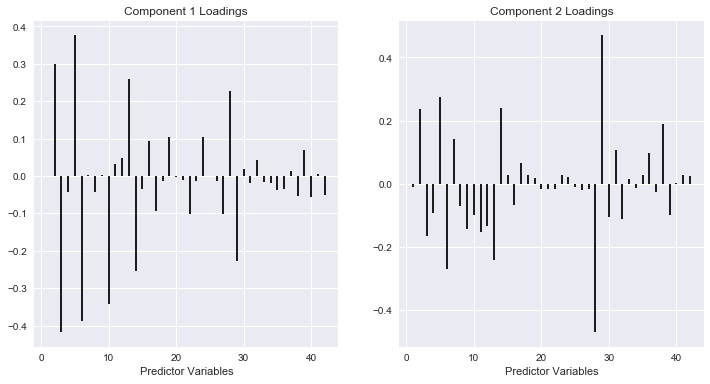

In [20]:
# PCA loadings
# Predictor Variables PCA

fig = plt.figure(figsize=(12, 6))
Comp1 = fig.add_subplot(121)
Comp2 = fig.add_subplot(122)

Comp1.vlines(range(1,n), [0],pca.components_[1,:])
Comp1.set_xlabel('Predictor Variables')
Comp1.set_title('Component 1 Loadings')

Comp2.vlines(range(1,n), [0],pca.components_[2,:])
Comp2.set_xlabel('Predictor Variables')
Comp2.set_title('Component 2 Loadings')

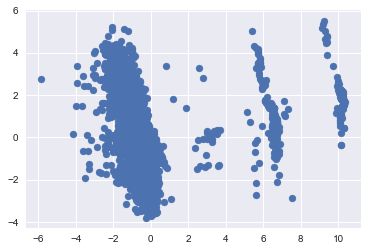

In [21]:
# # PCA scatter

plt.scatter(h1b_pca[:,0],h1b_pca[:,1])

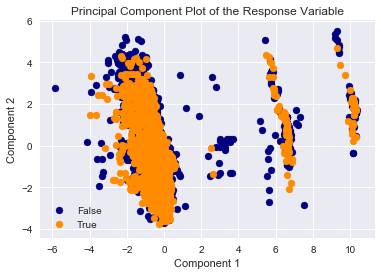

In [22]:
Certified = balance_df.OUTCOME == 1
# PCA plot with labels for certified
colors = ['navy', 'darkorange']

fig, ax = plt.subplots()
for i, color in  zip([False, True], colors):
        ax.scatter(h1b_pca[Certified == i, 0],
                   h1b_pca[Certified == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Response Variable')

## t-SNE with perplexity of 100

In [23]:
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random', perplexity =100,
                         random_state=42)

h1b_tsne = tsne.fit_transform(predictor_df)

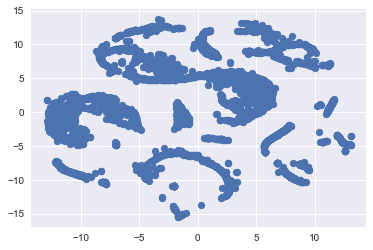

In [24]:
plt.scatter(h1b_tsne[:,0], h1b_tsne[:,1])

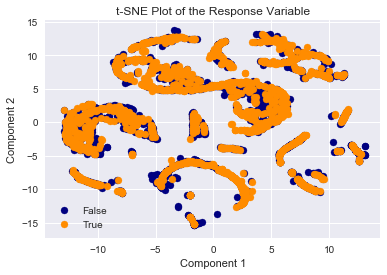

In [25]:
# PCA plot with labels for certified
colors = ['navy', 'darkorange']

fig, ax = plt.subplots()
for i, color in  zip([False, True], colors):
        ax.scatter(h1b_tsne[Certified == i, 0],
                   h1b_tsne[Certified == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of the Response Variable')

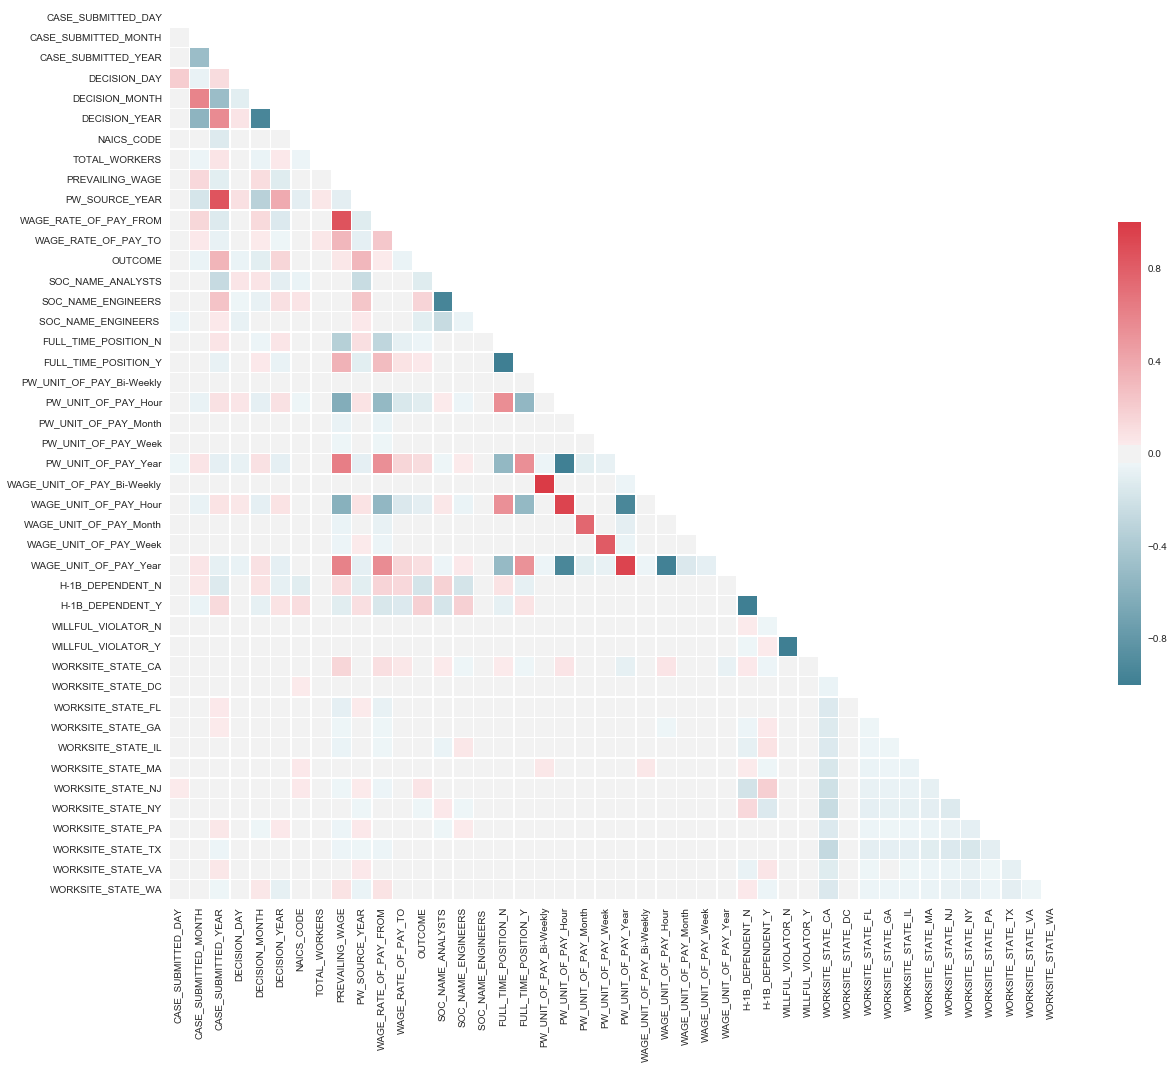

In [26]:
# Heat map to show correlations

sns.set(style="white")

# # Compute the correlation matrix
# for response variables
corr = balance_df.corr()

# # Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 17))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Baseline -- Logistic Regression

In [27]:
# Logistic Regression
# Main effect model with all variables

X_train, X_test, y_train, y_test = train_test_split(predictor_df, 
                                                    balance_df['OUTCOME'], random_state=42)


log_reg = linear_model.LogisticRegression()

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

In [28]:
# Cross Validation
cv_predicted = cross_val_predict(log_reg, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.68722165125
             precision    recall  f1-score   support

          0       0.72      0.63      0.67      1482
          1       0.66      0.74      0.70      1437

avg / total       0.69      0.69      0.69      2919



In [30]:
# Get the predicted probabilities
# and the FPR and TPR

y_pred = log_reg.predict_proba(X_test)
y_pred = y_pred[:,1]
log_reg_auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (log_reg_auc * 100.0))
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred)

AUC: 70.71%


# Naive Bayes

## Divide explanatory variables into continuous & binomial

In [31]:
predictor_df.dtypes

CASE_SUBMITTED_DAY              int64
CASE_SUBMITTED_MONTH            int64
CASE_SUBMITTED_YEAR             int64
DECISION_DAY                    int64
DECISION_MONTH                  int64
DECISION_YEAR                   int64
NAICS_CODE                    float64
TOTAL_WORKERS                   int64
PREVAILING_WAGE               float64
PW_SOURCE_YEAR                float64
WAGE_RATE_OF_PAY_FROM         float64
WAGE_RATE_OF_PAY_TO           float64
SOC_NAME_ANALYSTS               uint8
SOC_NAME_ENGINEERS              uint8
SOC_NAME_ENGINEERS              uint8
FULL_TIME_POSITION_N            uint8
FULL_TIME_POSITION_Y            uint8
PW_UNIT_OF_PAY_Bi-Weekly        uint8
PW_UNIT_OF_PAY_Hour             uint8
PW_UNIT_OF_PAY_Month            uint8
PW_UNIT_OF_PAY_Week             uint8
PW_UNIT_OF_PAY_Year             uint8
WAGE_UNIT_OF_PAY_Bi-Weekly      uint8
WAGE_UNIT_OF_PAY_Hour           uint8
WAGE_UNIT_OF_PAY_Month          uint8
WAGE_UNIT_OF_PAY_Week           uint8
WAGE_UNIT_OF

In [32]:
continuous_vars = predictor_df.select_dtypes(include=['int','float'])
binomial_vars = predictor_df.select_dtypes(exclude=['int','float'])

## Gaussian NB for continous variables only

In [33]:
X_train, X_test, y_train, y_test = train_test_split(continuous_vars, 
                                                    balance_df['OUTCOME'], random_state=42)


gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb_y_pred = gnb.predict_proba(continuous_vars)

In [34]:
# Cross Validation
cv_predicted = cross_val_predict(gnb, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.550873586845
             precision    recall  f1-score   support

          0       0.60      0.35      0.44      1482
          1       0.53      0.76      0.62      1437

avg / total       0.56      0.55      0.53      2919



## Bernoulli NB for binomial variables only

In [35]:
X_train, X_test, y_train, y_test = train_test_split(binomial_vars, 
                                                    balance_df['OUTCOME'], random_state=42)


bnb = BernoulliNB()

bnb.fit(X_train, y_train)

bnb_y_pred = bnb.predict_proba(binomial_vars)

In [36]:
# Cross Validation
cv_predicted = cross_val_predict(bnb, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.608427543679
             precision    recall  f1-score   support

          0       0.59      0.72      0.65      1482
          1       0.63      0.49      0.55      1437

avg / total       0.61      0.61      0.60      2919



## Stack the variables back together & refit a new Gaussian NB:
Transform all the dataset by taking the class assignment probabilities as new features and then refit a new model on the new features. 
Reference: ogrisel's answer to https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [37]:
X = np.hstack((gnb_y_pred, bnb_y_pred))
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    balance_df['OUTCOME'], random_state=42)


gnb_new = GaussianNB()

gnb_new.fit(X_train, y_train)

gnb_new_y_pred = gnb_new.predict_proba(X)

In [38]:
# Cross Validation
cv_predicted = cross_val_predict(gnb_new, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.611853374443
             precision    recall  f1-score   support

          0       0.60      0.70      0.65      1482
          1       0.63      0.52      0.57      1437

avg / total       0.61      0.61      0.61      2919



In [40]:
# Get the predicted probabilities
# and the FPR and TPR

y_pred = gnb_new.predict_proba(X_test)
y_pred = y_pred[:,1]
nb_auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (nb_auc * 100.0))
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, y_pred)

AUC: 61.25%


# Linear Discriminant Analysis

In [41]:
# Linear dicriminant

X_train, X_test, y_train, y_test = train_test_split(predictor_df, 
                                                    balance_df['OUTCOME'], random_state=42)

ld = LinearDiscriminantAnalysis()

ld.fit(X_train, y_train)

y_pred = ld.predict_proba(X_test)

In [42]:
# Cross Validation
cv_predicted = cross_val_predict(ld, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.702980472765
             precision    recall  f1-score   support

          0       0.75      0.62      0.68      1482
          1       0.67      0.79      0.72      1437

avg / total       0.71      0.70      0.70      2919



In [43]:
# Get the predicted probabilities
# and the FPR and TPR

y_pred = ld.predict_proba(X_test)
y_pred = y_pred[:,1]
ld_auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (ld_auc * 100.0))
ld_fpr, ld_tpr, ld_thresholds = roc_curve(y_test, y_pred)

AUC: 74.20%


# Quadratic Discriminant Analysis

In [44]:
# Quadratic dicriminant

X_train, X_test, y_train, y_test = train_test_split(predictor_df, 
                                                    balance_df['OUTCOME'], random_state=42)

qd = QuadraticDiscriminantAnalysis()

qd.fit(X_train, y_train)

y_pred = qd.predict_proba(X_test)

In [45]:
# Cross Validation
cv_predicted = cross_val_predict(qd, X_train, y_train, cv=10)
print (accuracy_score(y_train, cv_predicted))

print (classification_report(y_train, cv_predicted)) 

0.51421719767
             precision    recall  f1-score   support

          0       0.90      0.05      0.09      1482
          1       0.50      0.99      0.67      1437

avg / total       0.70      0.51      0.38      2919



In [46]:
# Get the predicted probabilities
# and the FPR and TPR

y_pred = qd.predict_proba(X_test)
y_pred = y_pred[:,1]
qd_auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (qd_auc * 100.0))
qd_fpr, qd_tpr, qd_thresholds = roc_curve(y_test, y_pred)

AUC: 56.78%


# 2D Mixture Model

## Use wage rate and prevailing wage as dimensions
As seen in the heatmap, they are most highly correlated with outcome

In [47]:
mix_df = pd.concat([balance_df['WAGE_RATE_OF_PAY_FROM'], balance_df['PREVAILING_WAGE']], axis=1)
data = mix_df.as_matrix()

## Initial plot of the data without labels

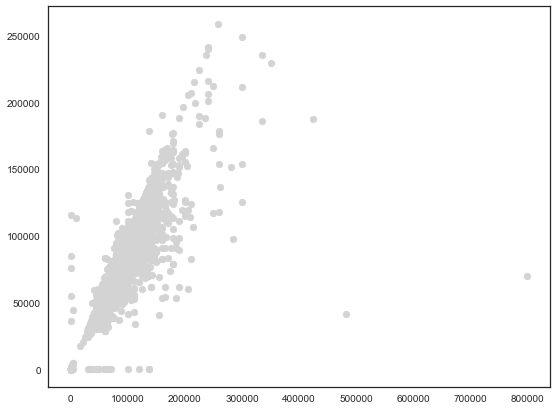

In [52]:
# plot initial
fig = plt.figure(figsize=[9,7])

ax = plt.scatter(data[:,0],data[:,1],c='lightgray',s=48,cmap=plt.colormaps()[29])

## Plot the distributions/ component classified by the mixture model

In [53]:
# Define the functions to draw the movement of the two distributions
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

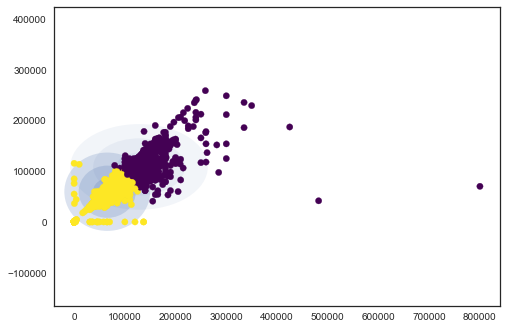

In [54]:
# Gausian mixture model
gmm = GMM(n_components=2, random_state=42)
plot_gmm(gmm, data)

## Actual oucome for comparison

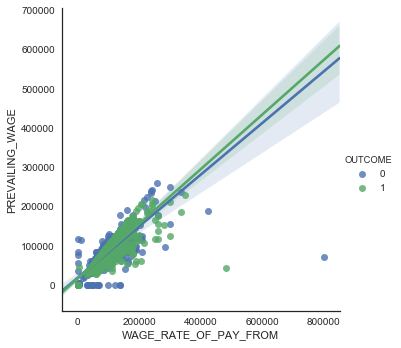

In [55]:
# Actual outcomes for comparison with the above graph classified by the mixture model
sns.lmplot("WAGE_RATE_OF_PAY_FROM","PREVAILING_WAGE", data=balance_df, hue='OUTCOME')

# ROC Curve  -- AUC comparison

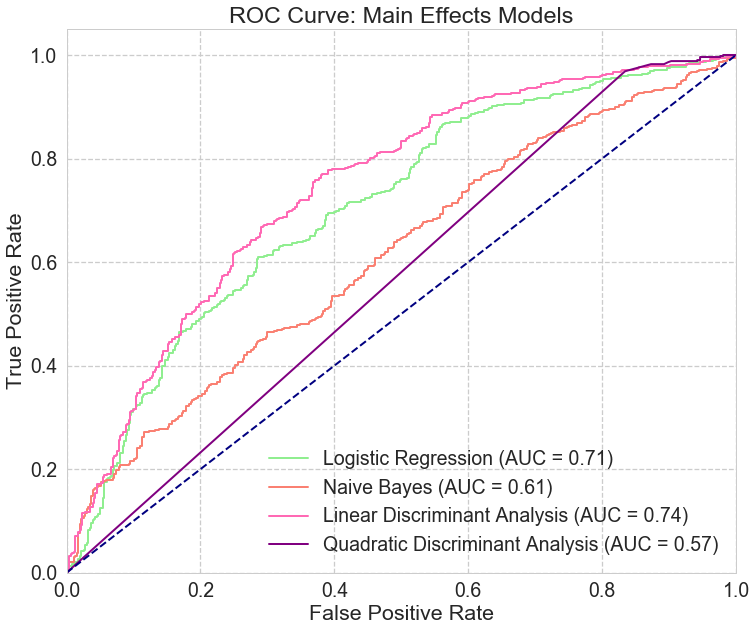

In [56]:
# ROC Plot


sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = [12,10])
plt.plot(lr_fpr, lr_tpr, color='lightgreen',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % log_reg_auc)
plt.plot(nb_fpr, nb_tpr, color='salmon',
         lw=lw, label='Naive Bayes (AUC = %0.2f)' % nb_auc)
plt.plot(ld_fpr, ld_tpr, color='hotpink',
         lw=lw, label='Linear Discriminant Analysis (AUC = %0.2f)' % ld_auc)
plt.plot(qd_fpr, qd_tpr, color='purple',
         lw=lw, label='Quadratic Discriminant Analysis (AUC = %0.2f)' % qd_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Main Effects Models')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()